# **Modelos de Classificação**


**O objetivo deste notebook é treinar modelos de aprendizado profundo para prever o rótulo/nome de uma determinada fruta tendo apenas uma imagem de entrada.**

## **O que é fast.ai?**

Em notebooks anteriores utilizamos diretamente a biblioteca PyTorch - https://pytorch.org/. Por conta da simplicidade iremos utilizar a biblioteca de alto nível fast.ai.

Fast.ai é uma biblioteca criada por Jeremy Howard e Rachel Thomas dedicada a tornar o poder do Aprendizado Profundo acessível a todos. Para tanto, argumentam que, para esse potencial ser atingido, a tecnologia tem de ser muito mais acessível, intuitiva e fácil de usar.







### **Referências**


* fast.ai—Making neural nets uncool again https://www.fast.ai/
* Deep Learning for Coders with Fastai and PyTorch: AI Applications Without a Ph - The fastai Book - https://github.com/fastai/fastbook
* https://codigos.ufsc.br/aldo.vw/vision/-/tree/master/jupyter

## **Bibliotecas utilizadas**

In [1]:
%%capture
!pip install gradio
!pip install opendatasets
!pip install fastai
!pip install timm

In [2]:
import os
import time
import copy
import random
import pandas as pd
import numpy as np
import tarfile
import matplotlib
import matplotlib.pyplot as plt
import opendatasets as od
import timm
import fastai
from fastdownload import download_url
from fastcore.all import *
from fastai.vision.all import *
from fastai.interpret import *
from fastai.vision.widgets import *
from pathlib import Path
from PIL import Image
from sklearn.metrics import classification_report

In [3]:
print(fastai.__version__)

2.7.13


## **Baixando dataset do Kaggle com OPENDATASETS**

In [4]:
od.download('https://www.kaggle.com/moltean/fruits')
#marcosvmedeiros
#d356a300e335f97bbf3559a47bb0d29f

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: marcosvmedeiros
Your Kaggle Key: ··········


100%|██████████| 1.28G/1.28G [00:22<00:00, 62.3MB/s]


In [5]:
data_dir = '/content/fruits/fruits-360_dataset/fruits-360'
print(os.listdir(data_dir))

['papers', 'LICENSE', 'readme.md', 'Test', 'test-multiple_fruits', 'Training']


In [6]:
len(os.listdir(data_dir + '/Training'))

131

Setando device

In [7]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [8]:
device = get_default_device()
device

device(type='cuda')

## **Carregando o Dataloader**

In [9]:
def get_dls(path, bs, size):
    dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items = get_image_files,
                       get_y = parent_label,
                       splitter = RandomSplitter(),
                       item_tfms = Resize(size),
                       batch_tfms=aug_transforms()
                      )
    return dblock.dataloaders(path, bs = bs)

In [10]:
train_dir = data_dir+'/Training'
test_dir = data_dir+'/Test'

### Visualizando um batch do conjunto de dados

In [11]:
dls = get_dls(train_dir, 64, 100) #Definindo Batch_size e Tamanho da Imagem Respectivamente

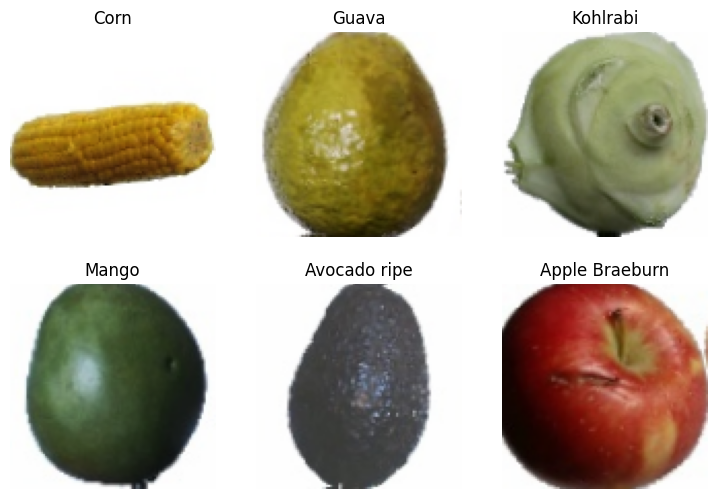

In [12]:
dls.show_batch(max_n=6)

## **Arquitetura do modelo**


Uma lista completa de modelos disponível em: https://github.com/fastai/fastai/tree/2.5.3/fastai/vision/models


Para mais modelos:
https://github.com/huggingface/pytorch-image-models/tree/main/timm/models

Selecionando a Rede Neural:

*   resnet18, resnet34, resnet50, resnet101, resnet152
*   squeezenet1_0, squeezenet1_1
*   densenet121, densenet169, densenet201, densenet161
*   vgg16_bn, vgg19_bn
*   alexnet

### Definindo Learner

Carregando as inicializações básicas para o aprendizado e definição dos parâmetros básicos da rede.

In [13]:
# Definir o array das métricas
metrics = [
    error_rate,
    accuracy,
    F1Score(average="macro"),
    Precision(average="macro"),
    Recall(average="macro"),
]

In [17]:
learn = vision_learner(dls, resnet34, loss_func = nn.CrossEntropyLoss(), metrics=metrics)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 91.0MB/s]


### Localizador de taxa de aprendizagem

O localizador de taxa de aprendizagem do fastai adiciona pontos nos locais recomendados.

O que procuramos é um local lógico no gráfico onde a perda está diminuindo. Os pontos vermelhos no gráfico indicam o valor mínimo do gráfico dividido por 10, bem como o ponto mais íngreme.

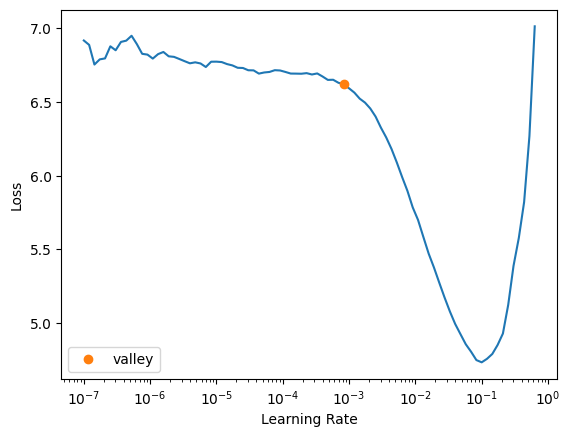

In [18]:
lr_min = learn.lr_find()
suggested_lr = min(lr_min)

Agora vamos ajustar o modelo como uma primeira etapa de treinamento.

In [19]:
learn.fine_tune(1, base_lr = suggested_lr)

epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,0.227483,0.039101,0.008421,0.991579,0.991682,0.991788,0.991852,02:37


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,0.018090,0.000638,0.000000,1.000000,1.000000,1.000000,1.000000,02:49


Agora que fizemos algum treinamento, precisaremos executar novamente o localizador de taxa de aprendizagem. À medida que o modelo muda e é treinado, podemos encontrar uma nova “melhor” taxa de aprendizagem.

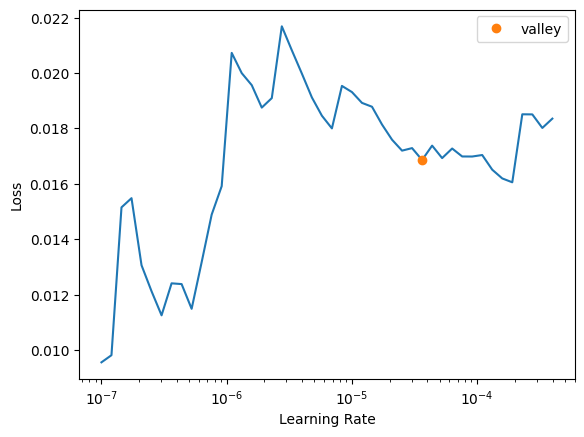

In [20]:
lr_min1 = learn.lr_find()
suggested_lr1 = min(lr_min)

In [21]:
suggested_lr1

0.0008317637839354575

In [22]:
learn.fit_one_cycle(1, suggested_lr1)

epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,0.011290,0.002507,0.000739,0.999261,0.999332,0.999361,0.999318,02:51


## **Treinamento do modelo**

### **O que é fit1cycle?**

Fit1cycle é uma política de superconvergência desenvolvida por Leslie N. Smith. Está disponível como a política de treinamento preferida no fast.ai. Veja abaixo os detalhes:

* https://docs.fast.ai/callbacks.one_cycle.html
* A disciplined approach to neural network hyper-parameters: Part 1 — learning rate, batch size, momentum, and weight decay — https://arxiv.org/abs/1803.09820
* Super-Convergence: Very Fast Training of Residual Networks Using Large Learning Rates — https://arxiv.org/abs/1708.07120

Treinamos utilizando a política de adaptação simultânea de taxa de aprendizado e momento linear da rede para superconvergência 1cycle

O método fit_one_cycle() empregado pelo fast.ai funciona com taxas e momentos de aprendizado variados e adaptativos, seguindo uma curva em que a taxa é aumentada e depois diminuída, enquanto o momento é tratado de forma oposta;

Se você interromper um treino na epoch 10 de, digamos, 20 epochs e depois recomeçar por mais 9 epochs, você não terá o mesmo resultado de treinar ininterruptamente por 20 epochs, porque um novo treino do zero, mesmo que você carregue os pesos da última época, empregarão uma nova taxa de aprendizado e política de impulso e passarão pelo ciclo novamente.

O que você quer é começar de onde você foi interrompido no ciclo.

In [ ]:
epochs = 10  # épocas
lr = suggested_lr1 # Incluir aqui a taxa de aprendizado encontrada no passo anterior
wd = 1e-2  # decaimento da rede

# Train
learn.fit_one_cycle(epochs, lr_max=lr) # wd=wd

epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,0.031698,0.017540,0.006426,0.993574,0.994534,0.995450,0.994395,02:49
1,0.114308,0.115594,0.032649,0.967351,0.967942,0.981163,0.965524,02:50
2,0.078718,0.040345,0.012779,0.987221,0.987306,0.990819,0.987138,02:54
3,0.039540,0.016191,0.004137,0.995863,0.995846,0.996948,0.995482,02:51
4,0.024125,0.005305,0.002290,0.997710,0.997606,0.997587,0.997847,02:54
5,0.009648,0.002278,0.000813,0.999187,0.999033,0.999125,0.999057,02:51
6,0.002352,0.000591,0.000222,0.999778,0.999779,0.999783,0.999779,02:52


### Visualizando resultados

In [ ]:
learn.show_results()

## **Salvando o modelo**

In [ ]:
learn.export("modelo_fruits.pkl")

### Encontrando as maiores perdas (top losses)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

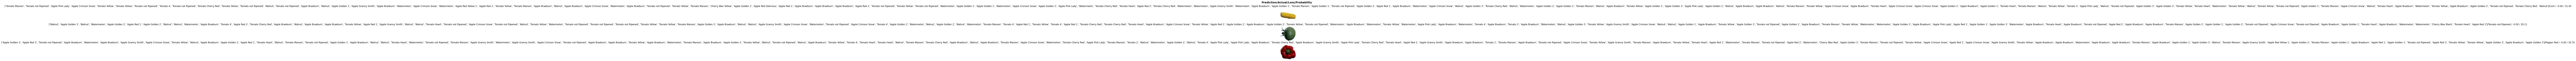

In [ ]:
interp.plot_top_losses(3, nrows=3, largest=False, figsize=(8,5))

In [ ]:
interp.plot_top_losses(3, nrows=3, figsize=(8,5))

In [ ]:
# Display heatmap of accuracy for each class
#interp.plot_confusion_matrix(figsize=(12, 12), cmap='Blues')

## **Utilizando o modelo em dados reais**

Fazendo o dowload de uma imagem para teste

In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/f/f7/Lemon_-_whole_and_split.jpg/1920px-Lemon_-_whole_and_split.jpg

--2023-12-07 02:40:33--  https://upload.wikimedia.org/wikipedia/commons/thumb/f/f7/Lemon_-_whole_and_split.jpg/1920px-Lemon_-_whole_and_split.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 326455 (319K) [image/jpeg]
Saving to: ‘1920px-Lemon_-_whole_and_split.jpg’

1920px-Lemon_-_whol 100%[===================>] 318.80K   551KB/s    in 0.6s    

2023-12-07 02:40:34 (551 KB/s) - ‘1920px-Lemon_-_whole_and_split.jpg’ saved [326455/326455]



Testando modelo com imagem baixada anteriormente.

In [ ]:
photo_type,_,probs = learn.predict(PILImage.create('1920px-Lemon_-_whole_and_split.jpg'))
print(f"This is a: {photo_type}.")
print(f"Probability is: {max(probs):.4f}")

This is a: ['Apple Crimson Snow', 'Tomato not Ripened', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Braeburn', 'Apple Braeburn', 'Walnut', 'Apple Golden 2', 'Apple Crimson Snow', 'Watermelon', 'Apple Braeburn', 'Apple Pink Lady', 'Apple Braeburn', 'Apple Granny Smith', 'Apple Braeburn', 'Apple Pink Lady', 'Apple Red 2', 'Apple Braeburn', 'Watermelon', 'Apple Braeburn', 'Apple Golden 2', 'Apple Braeburn', 'Walnut', 'Apple Red 2', 'Apple Golden 3', 'Apple Pink Lady', 'Walnut', 'Tomato not Ripened', 'Apple Braeburn', 'Apple Braeburn', 'Apple Braeburn', 'Watermelon', 'Walnut', 'Watermelon', 'Apple Granny Smith', 'Apple Braeburn', 'Apple Golden 2', 'Apple Golden 3', 'Apple Golden 1', 'Apple Golden 1', 'Apple Crimson Snow', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Crimson Snow', 'Apple Braeburn', 'Apple Braeburn', 'Apple Braeburn', 'Apple Golden 3', 'Apple Crimson Snow', 'Apple Braeburn', 'Apple Pink Lady', 'Apple Golden 2', 'Walnut', 'Apple Golden 1', 'Watermelon'

## **Fazendo Deploy do Modelo**

In [ ]:
import gradio as gr
from fastai.vision.all import *
import skimage

learn = load_learner('/content/modelo_fruits.pkl')

labels = learn.dls.vocab
def predict(img):
    img = PILImage.create(img)
    pred,pred_idx,probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

image_input = gr.Image(height=192, width=192)
label_output = gr.Label()

iface = gr.Interface(
    fn=predict,
    inputs=image_input,
    outputs=label_output,
    examples=['1920px-Lemon_-_whole_and_split.jpg'],
)

iface.launch()